In [1]:
%pwd
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dir = "./Data/Weather/"
%matplotlib inline
!mkdir -p $data_dir
!ls $data_dir

STAT.pickle                 ghcnd-stations.txt
STAT_TAVG_RANGE.pickle      ghcnd-stations_buffered.txt
SampleStations.pickle       ghcnd-version.txt
data-source.txt             stations.pkl
ghcnd-readme.txt


### Downloading Pickled data from S3
If `SampleStations.pickle` is not in the directory, get it using the following command

In [3]:
#!curl -o $data_dir/SampleStations.pickle http://mas-dse-open.s3.amazonaws.com/Weather/SampleStations.pickle

### Plot Reconstructions

From each measurement, we take 2 sample stations with low residual error and 2 sample stations with high residual error and plot the following:

* Original Data Vector
* Mean Vector
* Reconstructed Data Vector using mean and top 1 eigen vectors
* Reconstructed Data Vector using mean and top 2 eigen vectors
* Reconstructed Data Vector using mean and top 3 eigen vectors

### Read and Preprocess data

Read data from the pickle files `SampleStations.pickle` and `STAT.pickle`

* `SampleStations.pickle` contains information about the 6 measurements taken from some sample stations. You have been provided the code to process this file. It converts the seemingly complicated structure into a list of lists where each sublist has the following information:

`['station','measurement','year','1', '2', '3', ...... , '365']`

*  station - The station ID
*  measurement - One of the 6 types of measurements
*  year - The year in which the measurements were recorded
*  1-365 - The actual value of measurement for each day of the year



* `STAT.pickle` contains statistics about the weather data for each of the 6 measurements and its description.

In [4]:
import pickle
Data=pickle.load(open('./Data/Weather/SampleStations.pickle','r'))
STAT,STAT_description=pickle.load(open('./Data/Weather/STAT.pickle','r'))

In [5]:
FlatData=[]
for station in Data:
    stationname=station[0]
    for measurements in station[1]:
        measurement,year=measurements[0]
        yeardata=list(measurements[1])
        rowData=[stationname]+[measurement]+[year]+yeardata
        FlatData.append(rowData)

In [6]:
import pandas as pd

frameheader=['station','measurement','year']+range(1,366)
df=pd.DataFrame(FlatData,columns=frameheader)

m_df={}
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    t_df=df[df['measurement']==m]
    m_df[m]=t_df    

In [7]:
STAT_description

[('SortedVals',
  'Sample of values',
  'vector whose length varies between measurements'),
 ('UnDef',
  'sample of number of undefs per row',
  'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))]

In [8]:
Mean_vectors=STAT['TMIN']['Mean']
normal_data= m_df['TMIN'].drop(['station','measurement','year'], axis=1)-Mean_vectors

In [9]:
stations = m_df[m]
original = np.array(stations.ix[:,3:])
mean = STAT[m]['mean']

Mean_vectors=STAT[m]['Mean']
normal_data= m_df[m].drop(['station','measurement','year'], axis=1)-Mean_vectors
eigvectors=STAT[m]['eigvec']
Recon_Error={}
Reconstructed={}

U=eigvectors[:,0:2]  # (365, 1) Select number of eigenvectors to use
UT=transpose(U)  # (1, 365) Tranpose eigenvectors
UUT=np.dot(U, UT)  # (365, 365) dot product U and U-Tranpose
reconstructed=np.dot(UUT, normal_data.T) #(365, 5830) reconstrcuted without the mean
x =(reconstructed.T+STAT[m]['Mean']).T  # (365, 5830) add back the mean
Reconstructed[1]=x

error = (normal_data - reconstructed.T)**2 #(5830, 365) # dont add back the mean for this step 
mse = np.mean(np.nan_to_num(error), axis=1) #(5830,)
mse[mse==0]=numpy.nan #convert 0s back to nan
Recon_Error[2] = mse

errors = Recon_Error[2]
mask = np.isnan(errors)
errors[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), errors[~mask])
sorted_indicies = errors.argsort()

low_i = sorted_indicies[0:2]
high_i = sorted_indicies[-2:]

lower = low_i
upper = high_i

print lower
#original[lower[0]]

[4936 8097]


In [10]:
errors

array([ 4778.1026934 ,  4778.1026934 ,  4778.1026934 , ...,  1837.17244118,
        1837.17244118,  1837.17244118])

### Define Reconstruction Function

You need to plot reconstructions for two stations with low reconstruction error and two stations with high reconstruction error. To do this, you will need to do the following:

1. Calculate the reconstruction error for the data vector reconstructed using mean and top-3 eigenvectors.
2. Remove the ones for which reconstruction error is NaN.
3. Choose two with the lowest and two with the highest reconstruction error for plotting.

In [11]:
def create_reconstructions(m):  
    stations = m_df[m]
    original = np.array(stations.ix[:,3:])
    
    #original=m_df[m]
    #stations = m_df[m]
    original = np.array(stations.ix[:,3:])

    mean = STAT[m]['mean']
    
    Mean_vectors=STAT[m]['Mean']
    normal_data= m_df[m].drop(['station','measurement','year'], axis=1)-Mean_vectors
    eigvectors=STAT[m]['eigvec']
    Recon_Error={}
    Reconstructed={}
    
    for i in range(1,4):  
        U=eigvectors[:,0:i]  # (365, 1) Select number of eigenvectors to use
        UT=transpose(U)  # (1, 365) Tranpose eigenvectors
        UUT=np.dot(U, UT)  # (365, 365) dot product U and U-Tranpose
        reconstructed=np.dot(UUT, normal_data.T) #(365, 5830) reconstrcuted without the mean
        recon_original =(reconstructed.T+STAT[m]['Mean']).T  # (365, 5830) add back the mean
        print shape(recon_original)
        Reconstructed[i]=recon_original
        
        error = (normal_data - reconstructed.T)**2 #(5830, 365) # dont add back the mean for this step 
        mean_squared_err = np.mean(np.nan_to_num(error), axis=1) #(5830,)
        mean_squared_err[mean_squared_err==0]=numpy.nan #convert 0s back to nan
        Recon_Error[i] = mean_squared_err
        
        errors = Recon_Error[i]
        mask = np.isnan(errors)
        errors[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), errors[~mask])
        sorted_indicies = errors.argsort()

        lower = sorted_indicies[0:2]
        upper = sorted_indicies[-2:]


    yeardays=[i for i in (1,366)]
    plt.figure(figsize=(20,30),dpi=300)
    j=1
    c=0
    for l in lower:
        subplot(4,2,j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (low residual error)')
        xlim([0,365])
        legend(['original','Mean','1','2','3'],loc=2)
    
    c=0
    for l in upper:
        subplot(4,2,j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (high residual error)')
        xlim([0,365])
        legend(['original','Mean','1','2','3'],loc=2)

Reconstruction Plots for TMAX
(365, 5835)
(365, 5835)
(365, 5835)
Reconstruction Plots for SNWD
(365, 6549)
(365, 6549)
(365, 6549)


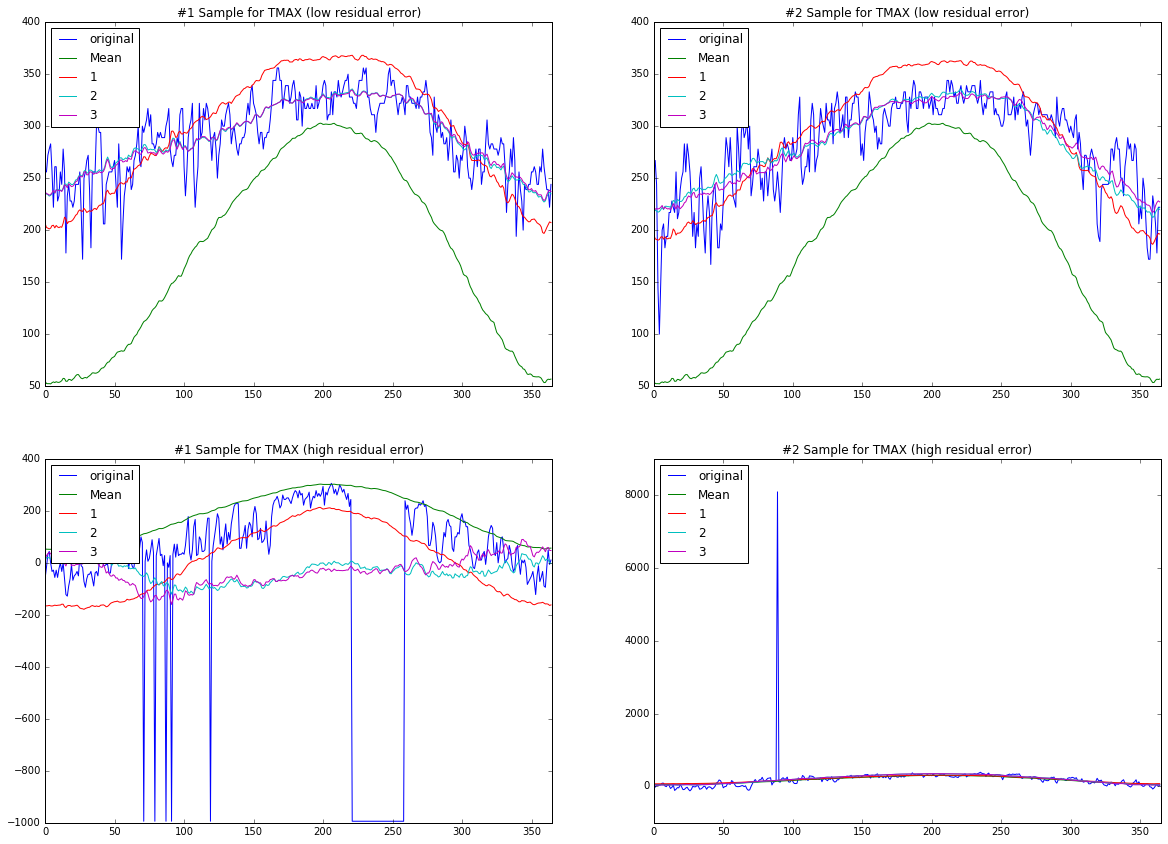

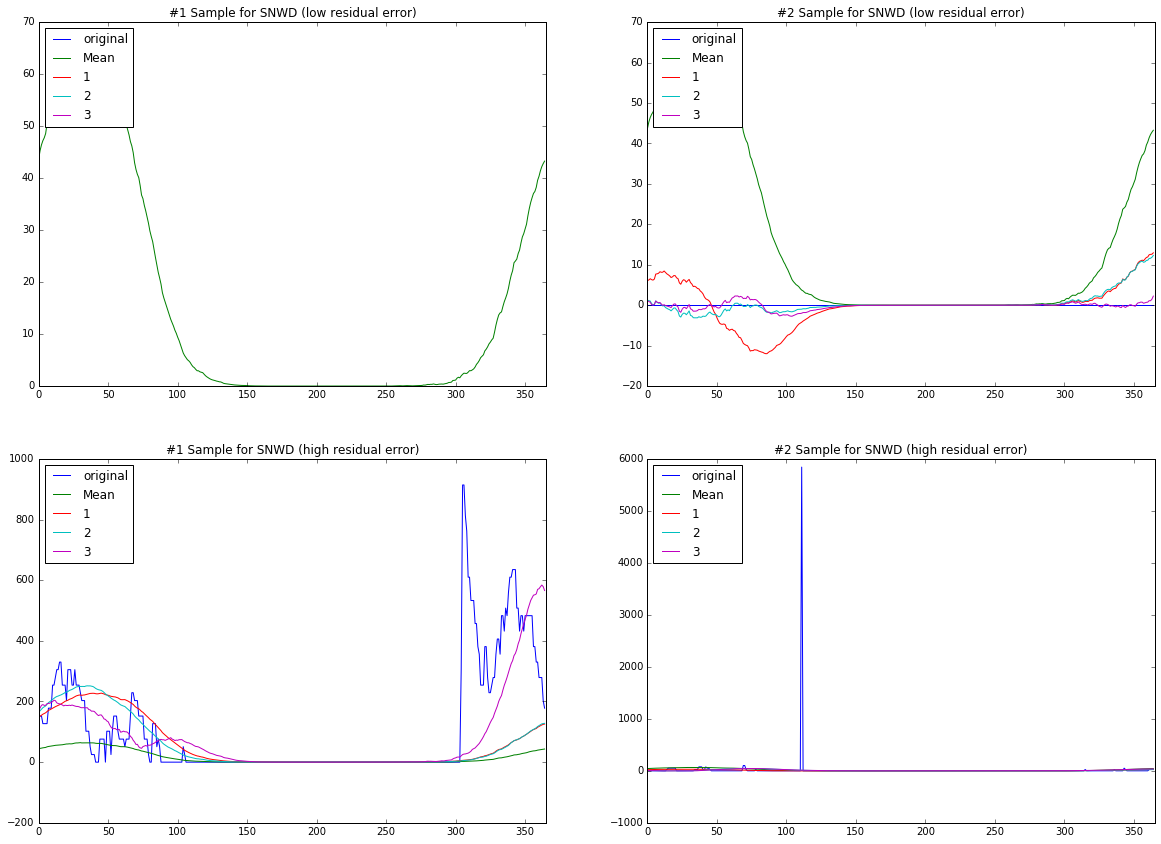

In [12]:
for m in ['TMAX','SNWD']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)